In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/ESRGAN

/content/drive/MyDrive/ESRGAN


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim
from torchvision.models.vgg import vgg16
from math import exp
import torch
import torch.nn.functional as F
import torchvision.utils as utils
from torch.autograd import Variable
from tqdm import tqdm
import math
import pandas as pd
import os
from os import listdir
import numpy as np
from PIL import Image
from os.path import join
import cv2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
upscale_factor = 8
crop_size= 88
num_epochs= 100

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
def is_image(filename):
  return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

def calc_valid_crop_size(crop_size,upscale_factor):
  return crop_size - (crop_size % upscale_factor)

def train_high_res_transform(crop_size):
  return transforms.Compose([transforms.RandomCrop(crop_size), transforms.ToTensor()])

def train_low_res_transform(crop_size,upscale_factor):
  return transforms.Compose([transforms.ToPILImage(), transforms.Resize(crop_size//upscale_factor, interpolation = Image.BICUBIC), transforms.ToTensor()])


In [ ]:
class TrainDataFromFolder(Dataset):
  def __init__(self,data_dir, crop_size, upscale_factor):
    super().__init__()
    self.image_file_names = [join(data_dir,x) for x in listdir(data_dir) if is_image(x)]
    crop_size = calc_valid_crop_size(crop_size, upscale_factor)
    self.high_res_transform = train_high_res_transform(crop_size)
    self.low_res_transform = train_low_res_transform(crop_size,upscale_factor)

  def __getitem__(self,index):
    hr_image = self.high_res_transform(Image.open(self.image_file_names[index]))
    lr_image = self.low_res_transform(hr_image)
    return lr_image, hr_image

  def __len__(self):
    return len(self.image_file_names)

In [ ]:
class ValDataFromFolder(Dataset):
  def __init__(self,data_dir, upscale_factor):
    super().__init__()
    self.upscale_factor = upscale_factor
    self.image_file_names = [join(data_dir,x) for x in listdir(data_dir) if is_image(x)]

  def __getitem__(self,index):
    hr_image = Image.open(self.image_file_names[index])
    w,h = hr_image.size
    crop_size = calc_valid_crop_size(min(w,h), self.upscale_factor)
    lr_scale = transforms.Resize(crop_size // self.upscale_factor, interpolation=Image.BICUBIC)
    hr_scale = transforms.Resize(crop_size, interpolation=Image.BICUBIC)
    hr_image = transforms.CenterCrop(crop_size)(hr_image)
    lr_image = lr_scale(hr_image)
    hr_restored_image = hr_scale(lr_image)
    return transforms.ToTensor()(lr_image), transforms.ToTensor()(hr_restored_image), transforms.ToTensor()(hr_image)

  def __len__(self):
    return len(self.image_file_names)


In [ ]:
#Original
train_set = TrainDataFromFolder('/content/drive/MyDrive/ESRGAN/Data/train_HR', crop_size=crop_size, upscale_factor=upscale_factor)
val_set = ValDataFromFolder('/content/drive/MyDrive/ESRGAN/Data/train_LR', upscale_factor=upscale_factor)
train_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=4, batch_size=1, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# train_set = TrainDataFromFolder('/content/drive/MyDrive/ESRGAN/Data/train/high_res', crop_size=crop_size, upscale_factor=upscale_factor)
# val_set = ValDataFromFolder('/content/drive/MyDrive/ESRGAN/Data/train/low_res', upscale_factor=upscale_factor)
# train_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=64, shuffle=True)
# val_loader = DataLoader(dataset=val_set, num_workers=4, batch_size=1, shuffle=False)

In [ ]:
for batch in train_loader:
  print(batch)
  break

[tensor([[[[0.0667, 0.0902, 0.0784,  ..., 0.1686, 0.1059, 0.1373],
          [0.0902, 0.1020, 0.0941,  ..., 0.2314, 0.1176, 0.1490],
          [0.1333, 0.0863, 0.1098,  ..., 0.1137, 0.1137, 0.1765],
          ...,
          [0.0902, 0.0784, 0.0784,  ..., 0.2902, 0.1020, 0.1137],
          [0.1451, 0.1059, 0.0784,  ..., 0.2353, 0.1216, 0.1961],
          [0.0824, 0.0667, 0.0980,  ..., 0.1765, 0.1176, 0.2863]],

         [[0.1451, 0.1373, 0.1490,  ..., 0.3608, 0.2863, 0.2392],
          [0.2275, 0.1961, 0.1373,  ..., 0.3804, 0.1882, 0.2392],
          [0.2196, 0.1451, 0.1608,  ..., 0.2314, 0.1882, 0.3020],
          ...,
          [0.2000, 0.1765, 0.1569,  ..., 0.4353, 0.1804, 0.2235],
          [0.2000, 0.1412, 0.1490,  ..., 0.3765, 0.1961, 0.3020],
          [0.1294, 0.1529, 0.1804,  ..., 0.2745, 0.1961, 0.4314]],

         [[0.0667, 0.0706, 0.0588,  ..., 0.2118, 0.1020, 0.0980],
          [0.0627, 0.0706, 0.0549,  ..., 0.2706, 0.0863, 0.1059],
          [0.1137, 0.0275, 0.0667,  ..., 

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)
  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + residual

In [ ]:
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                          kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()
  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

In [ ]:
class Generator(nn.Module):
  def __init__(self, scale_factor):
    super(Generator, self).__init__()
    upsample_block_num = int(math.log(scale_factor, 2))

    self.block1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )

    self.block2 = ResidualBlock(64)
    self.block3 = ResidualBlock(64)
    self.block4 = ResidualBlock(64)
    self.block5 = ResidualBlock(64)
    self.block6 = ResidualBlock(64)
    self.block7 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
    block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
    self.block8 = nn.Sequential(*block8)
  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    block7 = self.block7(block6)
    block8 = self.block8(block1 + block7)
    return (torch.tanh(block8) + 1) / 2


In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1)
    )
  def forward(self, x):
    batch_size=x.size()[0]
    return torch.sigmoid(self.net(x).view(batch_size))


In [ ]:
class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    count_h = self.tensor_size(x[:, :, 1:, :])
    count_w = self.tensor_size(x[:, :, :, 1:])

    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  @staticmethod
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]

In [ ]:

class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss, self).__init__()
    vgg = vgg16(pretrained=True)
    loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
    for param in loss_network.parameters():
      param.requires_grad = False
    self.loss_network = loss_network
    self.mse_loss = nn.MSELoss()
    self.tv_loss = TVLoss()
  def forward(self, out_labels, out_images, target_images):
    adversial_loss = torch.mean(1 - out_labels)
    perception_loss = self.mse_loss(out_images, target_images)
    image_loss = self.mse_loss(out_images, target_images)
    tv_loss = self.tv_loss(out_images)
    return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss

In [ ]:
netG = Generator(upscale_factor)
netD = Discriminator()

In [ ]:
generator_criterion = GeneratorLoss()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 95.4MB/s]


In [ ]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [ ]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)


In [ ]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}


In [ ]:
for epoch in range(1, num_epochs + 1):
        train_bar = tqdm(train_loader)
        running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

        netG.train()
        netD.train()
        for data, target in train_bar:
            g_update_first = True
            batch_size = data.size(0)
            running_results['batch_sizes'] += batch_size

            ############################
            # (1) Update D network: maximize D(x)-1-D(G(z))
            ###########################
            real_img = Variable(target)
            if torch.cuda.is_available():
                real_img = real_img.cuda()
            z = Variable(data)
            if torch.cuda.is_available():
                z = z.cuda()
            fake_img = netG(z)

            netD.zero_grad()
            real_out = netD(real_img).mean()
            fake_out = netD(fake_img).mean()
            d_loss = 1 - real_out + fake_out
            d_loss.backward(retain_graph=True)
            optimizerD.step()

            ############################
            # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
            ###########################
            netG.zero_grad()
            ## The two lines below are added to prevent runetime error in Google Colab ##
            fake_img = netG(z)
            fake_out = netD(fake_img).mean()
            ##
            g_loss = generator_criterion(fake_out, fake_img, real_img)
            g_loss.backward()

            fake_img = netG(z)
            fake_out = netD(fake_img).mean()


            optimizerG.step()

            # loss for current batch before optimization
            running_results['g_loss'] += g_loss.item() * batch_size
            running_results['d_loss'] += d_loss.item() * batch_size
            running_results['d_score'] += real_out.item() * batch_size
            running_results['g_score'] += fake_out.item() * batch_size

            train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
                epoch, num_epochs, running_results['d_loss'] / running_results['batch_sizes'],
                running_results['g_loss'] / running_results['batch_sizes'],
                running_results['d_score'] / running_results['batch_sizes'],
                running_results['g_score'] / running_results['batch_sizes']))

        netG.eval()

        with torch.no_grad():
            val_bar = tqdm(val_loader)
            valid_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
            val_images = []
            for val_lr, val_hr_restore, val_hr in val_bar:
                batch_size = val_lr.size(0)
                valid_results['batch_sizes'] += batch_size
                lr = val_lr
                hr = val_hr
                if torch.cuda.is_available():
                    lr = lr.cuda()
                    hr = hr.cuda()
                sr = netG(lr)

                batch_mse = ((sr - hr) ** 2).data.mean()
                valid_results['mse'] += batch_mse * batch_size
                batch_ssim = ssim(sr, hr).item()
                valid_results['ssims'] += batch_ssim * batch_size
                valid_results['psnr'] = 10 * math.log10((hr.max()**2) / (valid_results['mse'] / valid_results['batch_sizes']))
                valid_results['ssim'] = valid_results['ssims'] / valid_results['batch_sizes']
                val_bar.set_description(
                    desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                        valid_results['psnr'], valid_results['ssim']))

        if not os.path.exists('epochs/'):
          os.makedirs('epochs/')
        # save model parameters
        if epoch%10==0:
          torch.save(netG.state_dict(), 'epochs/netG_epoch_%d_%d.pth' % (upscale_factor, epoch))
          torch.save(netD.state_dict(), 'epochs/netD_epoch_%d_%d.pth' % (upscale_factor, epoch))
        # save loss\scores\psnr\ssim
        results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
        results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
        results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
        results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
        results['psnr'].append(valid_results['psnr'])
        results['ssim'].append(valid_results['ssim'])

        if epoch % 10 == 0 and epoch != 0:
            out_path = 'statistics/'
            if not os.path.exists(out_path):
              os.makedirs(out_path)

            data_frame = pd.DataFrame(
                data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                      'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim']},
                index=range(1, epoch + 1))
            data_frame.to_csv(out_path + 'srf_' + str(upscale_factor) + '_train_results.csv', index_label='Epoch')


[1/100] Loss_D: 0.9798 Loss_G: 0.0711 D(x): 0.5105 D(G(z)): 0.4510: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]
[converting LR images to SR images] PSNR: 11.0594 dB SSIM: 0.3293: 100%|██████████| 834/834 [01:48<00:00,  7.70it/s]
[2/100] Loss_D: 0.8611 Loss_G: 0.0640 D(x): 0.5777 D(G(z)): 0.4028: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]
[converting LR images to SR images] PSNR: 11.2655 dB SSIM: 0.3312: 100%|██████████| 834/834 [00:41<00:00, 20.24it/s]
[3/100] Loss_D: 0.7947 Loss_G: 0.0532 D(x): 0.6139 D(G(z)): 0.3735: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]
[converting LR images to SR images] PSNR: 12.1363 dB SSIM: 0.3310: 100%|██████████| 834/834 [00:39<00:00, 21.02it/s]
[4/100] Loss_D: 0.7576 Loss_G: 0.0357 D(x): 0.6374 D(G(z)): 0.3201: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]
[converting LR images to SR images] PSNR: 11.5470 dB SSIM: 0.3275: 100%|██████████| 834/834 [00:40<00:00, 20.83it/s]
[5/100] Loss_D: 0.7027 Loss_G: 0.0299 D(x): 0.6146 D(G(z)): 0.2893: 100%|███

## **Testing** **Images**

Model path RRDB_ESRGAN_x4.pth. 
Testing...


Saving sample2.png to sample2 (1).png


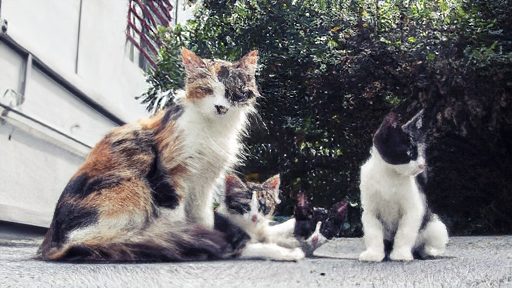

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os.path as osp
import glob
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow
# from IPython.display import display, HTML
import numpy as np
import torch
import RRDBNet_arch as arch

model_path = 'RRDB_ESRGAN_x4.pth'
device = torch.device('cuda')
# device = torch.device('cpu')

test_img_folder = 'LR/*'

model = arch.RRDBNet(3, 3, 64, 23, gc=32)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model = model.to(device)

print('Model path {:s}. \nTesting...'.format(model_path))
###---- For Testing floder of images -----##:

# idx = 0
# for path in glob.glob(test_img_folder):
#     idx += 1
#     base = osp.splitext(osp.basename(path))[0]
#     print(idx, base)
#     # read images
#     img = cv2.imread(path, cv2.IMREAD_COLOR)
#     img = img * 1.0 / 255
#     img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
#     img_LR = img.unsqueeze(0)
#     img_LR = img_LR.to(device)

#     with torch.no_grad():
#         output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
#     output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
#     output = (output * 255.0).round()
#     cv2.imwrite('results/{:s}_rlt.png'.format(base), output)
#     cv2_imshow(output)



####---- For testing folder of images #####--

uploaded = files.upload()
file_name = list(uploaded.keys())[0]

img = cv2.imread(file_name, cv2.IMREAD_COLOR)
img = img * 1.0 / 255
img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
img_LR = img.unsqueeze(0)
img_LR = img_LR.to(device)

with torch.no_grad():
    output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
output = (output * 255.0).round()
# cv2.imwrite('results/{:s}_rlt.png'.format(base), output)
cv2_imshow(output)
file_name='processed_image.png'
cv2.imwrite(file_name,output)
#Makes automatic download
files.download(file_name)
